# Реализация DQN

В этом уроке мы разберем на практике обучение DQN (Deep Q Network) для задачи Pong.

### Загрузка библиотек

Для обучения нейросети будем использовать TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym.wrappers import Monitor

import tensorflow as tf

In [ ]:
!conda install gym[atari]

In [ ]:
!pip3 install gym[atari]

In [ ]:
!pip install autorom
!AutoROM --accept-license

In [ ]:
!ale-import-roms /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/AutoROM/roms/

### Создание игровой среды
Создадим симулятор Pong.

In [2]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

States shape: (210, 160, 3)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


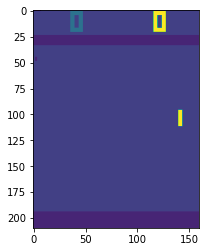

In [3]:
s = env.reset()
j = 0
_=plt.imshow(s[:,:,2])

(160, 160)


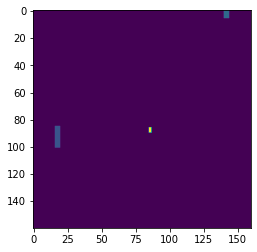

In [139]:
print(s[34:194,:,2].shape) # можно обрезать
_=plt.imshow(s[34:194,:,2])

шаг 10
3
2
Reward:  0.0
Done?  False


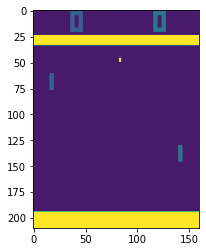

In [13]:
#a = env.action_space.sample()
j += 1 # счетчик
print(f'шаг {j}')

for i in range(2):
  a = int(np.random.rand()*2) + 2 # действие 2 или 3
  print(a)
  env.step(a)
  s1, r, done, _ = env.step(a)
print('Reward: ', r)
print('Done? ', done)
_=plt.imshow(s1[:,:,2])

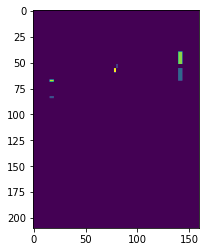

In [12]:
s = s1
s1, r, done, _ = env.step(a)
_=plt.imshow((s-s1)[:,:,2])

### Создание модели



In [14]:
#States shape: (210, 160, 3)

DIM = 16 # пробовал до 64
model = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPool2D((8, 8)),
    #tf.keras.layers.Conv2D(DIM, (3, 3), padding='same', activation='relu', use_bias=False),
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(DIM*2, (3, 3), padding='same', activation='relu', use_bias=False),                        
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(DIM*4, (3, 3), padding='same', activation='relu', use_bias=False),                       
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(DIM*4, (3, 3), padding='same', activation='relu', use_bias=False),                       
    #tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(DIM*4, (20, 20), padding='valid', activation='relu', use_bias=False),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.initializers.RandomUniform(0, 1),
    #                      ),    
    #tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.initializers.RandomUniform(0, 1),
    #                      ),
    #tf.keras.layers.Dense(32, activation='sigmoid', kernel_initializer=tf.initializers.RandomUniform(0, 1),
    #                      use_bias=False),
    #tf.keras.layers.Lambda(lambda x: x * 0.9), # получались результаты очень близкие к 1
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_initializer=tf.initializers.RandomUniform(0, 1),
                          use_bias=False) # NUM_ACTIONS
])

def evalQ(s):
    inp = s[34:194,:,2].reshape(160,160,1) # берем один канал
    inp = np.array([inp/255], dtype=np.float32)
    return model(inp).numpy()[0]

#model.build((None, 210, 160, 1))
inp = s1[34:194,:,2].reshape(160,160,1) # берем один канал
model(np.array([inp/255], dtype=np.float32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (1, 20, 20, 1)            0         
_________________________________________________________________
conv2d (Conv2D)              (1, 1, 1, 64)             25600     
_________________________________________________________________
flatten (Flatten)            (1, 64)                   0         
_________________________________________________________________
dense (Dense)                (1, 2)                    128       
Total params: 25,728
Trainable params: 25,728
Non-trainable params: 0
_________________________________________________________________


In [15]:
x= np.random.uniform(0,1,size=(210, 160, 3))
evalQ(x)

array([0.5019887, 0.5018346], dtype=float32)

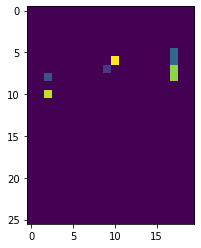

In [13]:
inp = (s1-s)[:,:,2].reshape(210,160,1) # что видит модель
inp =  tf.constant([inp], dtype=tf.int32)
conv = tf.keras.layers.MaxPool2D((8, 8))
out = conv(inp)
_=plt.imshow(out[0])

### Параметры обучения

* `lr` - скорость обучения (в теории это был параметр `alpha`)
* `gamma` - параметр дисконтирования
* `NUM_EPISODES` - сколько всего эпизодов игры будем осуществлять
* `MAX_STEPS` - максимальное количесвто шагов в рамках одного эпизода. Эпизод может закончиться и раньше. Это ограничение нужно, если агент зашёл в какой-то тупик и там застрял. Или для бесконечных игр/симуляций.

Кроме того, будем смотреть на награду, усреднённую в некотором временнОм окне (окно по эпизодам).

* `REWARD_AVERAGE_WINDOW` - размер этого окна.

In [20]:
lr = 0.01 # learning rate
gamma = 0.7 # параметр дисконтирования. уменьшил, важны последние 10-20 действий

NUM_EPISODES = 2000 # число эпизодов для обучения
MAX_STEPS = 50000 # максимальное число шагов в эпизоде

REWARD_AVERAGE_WINDOW = 20 # окно для усреднения наград по эпизодам

### Подготовка к обучению

В качестве функции потерь будем использовать квадрат нормы разницы между целевым и предсказанным вектором Q(s, :), как это обычно делается в задачах регрессии (ведь нам нужно притянуть друг к другу эти два вектора). Зададим это функцией `loss()`

В качестве оптимизатора для нейросети будем использовать SGD.

In [17]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2)) # tf.square(

#optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(loss=loss, optimizer=optimizer)

In [19]:
optimizer.learning_rate = 0.001

# Experience replay

### Обучение DQN

Обучение DQN во многом похоже на табличный Q-Learning. Рассмотрим подробнее лишь те части, котороые отличаются.

Чтобы получить значения Q-функции для текущего состояния `s` и всех действий, воспользуемся функцией `evalQ`: 

`Q_s = evalQ(s)`

Во время обучения будем использовать eps-greedy подход для выбора действия (в зависимости от параметра `eps` выбирать случайное действие или по текущей политике).

Самое интересное -- как сделать обновление Q-функции. Для начала, надо разобраться, как получить целевой вектор Q-target. Вспомним, что в Q-Learning мы должны обновить только значение `Q(s, a)` (через уравнение Беллмана). Но так как нейросеть предсказывает веткор для всех возможных действий (`Q(s, :)`), сделать нужно следующим образом.

 Пусть целевой вектор для `Q(s, :)` будет равен исходным (предсказанным нейросетью) значениям для всех действий, кроме действия `a`. То есть скопируем в `Q_target` текущий предсказанный `Q_s` и заменим в нём лишь `Q_target[a]` на та, что дает нам Беллман. И теперь наша задача "обучить" нейросеть на этот целевой вектор, то есть заставить её изменить свои веса так, чтобы только значение для действия `a` изменилось, а остальные значения `Q(s, :)` по возможности не изменялись. Делаем это через минимизацию ошибки между этими векторами.

А чтобы сделать один шаг минимизации ошибки, нам надо сделать один шаг градиентного спуска (или в общем случае один шаг обучения модели). Сделать это можно с помощью функции `model.train_on_batch(...)`, которая делает шаг обучения на данном батче. На входе у неё батч входов и батч правильных ответов. У нас будет батч из одного элемента.

В остальном всё то же самое, как было в Q-Learning.

И еще дополнительно накапливаем список "усредненных в окне наград" -- `totalRewardAverageList`

In [21]:
from random import sample
import sys


pathLenList = [] # длины траекторий по эпизодам
totalRewardList = [] # суммарные награды по эпизодам
totalRewardAverageList = [] # суммарные награды по эпизодам (среднее по окну)

REPLAY_BUFFER_LEN = 200
MINI_BATCH_LEN = 40
LEARNING_STEP = MINI_BATCH_LEN # / 2

sars_list = []
mbatch_indx = []

def evalQ_batch(s): # инференс батчем
    inp = s[:,34:194,:,2].reshape(-1,160,160,1) # берем один канал
    inp = np.array(inp/255, dtype=np.float32)
    return model(inp).numpy()

def update_q(i, sars_list):
  
  mbatch_indx = [i for i in range(len(sars_list))]
  mbatch_indx = sample(mbatch_indx, MINI_BATCH_LEN) # random indxs
  
  sars_list = np.array(sars_list)
  s1 = sars_list[mbatch_indx, 4] # получаем список s1
  s1 = np.stack(s1, axis=0)
  #return s1
  Q_s1 = evalQ_batch(s1)
      
  # Новое (целевое) значение Q-функции
  Q_target = sars_list[mbatch_indx, 1]
  Q_target = np.stack(Q_target, axis=0)

  a = sars_list[mbatch_indx, 2]
  a = np.stack(a, axis=0)
  
  r = sars_list[mbatch_indx, 3]
  r = np.stack(r, axis=0)

  done = sars_list[mbatch_indx, 5]
  done = np.stack(done, axis=0)

  s = sars_list[mbatch_indx, 0] # получаем список s
  s = np.stack(s, axis=0)
  inp = s[:,34:194,:,2].reshape(-1,160,160,1) # берем один канал, кропим
  inp = np.array(inp/255, dtype=np.float32)

  for i in range(MINI_BATCH_LEN):
    if r[i] != 0:
        #if r[i] == 1:
        #    print(f'Qs = {Q_target[i]} a {a[i]} r {r[i]}') 
        Q_target[i,a[i]] = r[i]
        #print(f'Q_target = {Q_target[i]}') 
    else:
        #print(f'Qs = {Q_target[i]} a {a[i]} r {r[i]} Q_s1 {Q_s1[i]}') 
        Q_target[i,a[i]] = gamma * np.max(Q_s1[i])
        #print(f'Q_target = {Q_target[i]}') 
  
  if False:
    print('i =', i)
    print('Qs ', Q_target)
    print('Q_s1: ', Q_s1)
    print('a ', a)
    print(r)
    print('done ', done)    
    print('Q_target', Q_target)      

  # Обновление Q-функции
  history = model.train_on_batch(inp, Q_target)
  
  return history
        
def train_dqn(eps_del):                  # основной цикл
    avg_step_list = []    
    for i in range(NUM_EPISODES): #NUM_EPISODES): 

        eps = (1.0 - i / NUM_EPISODES) * eps_del

        s = env.reset()
        s0 = s            # предыдущее состояние

        totalReward = 0
        step = 0
        a_list = []


        while step < MAX_STEPS:
            step += 1

            Q_s = evalQ(s- s0) # посылаем разницу между кадрами

            if np.random.rand() < eps: # действий всего 2, изучать особо нечего
                # Выбор случайного действия
                a = int(np.random.rand()*2) + 2 # действие 2 или 3
            else:
                # Выбор действия по текущей политике
                a = np.argmax(Q_s) + 2

            # Сделать шаг
            a_list.append(a)

            s1, r, done, _ = env.step(a)

            totalReward += r
            #if r==-1: r = 0 # пробую не штрафовать
            #

            if True: #np.random.rand() < eps: # повторяем действие      
              if (not done) and (r == 0):         # Если предыдущее действие не привело к концу эпизода      
                #s = s1.copy()
                s1, r, done, _ = env.step(a)
                sars_list.append((s, Q_s, a-2, r, s1-s, done)) # записываем результаты
                step += 1
                totalReward += r
              else:
                sars_list.append((s, Q_s, a-2, r, s1-s, done)) # записываем результаты первого шага
            else:
                sars_list.append((s, Q_s, a-2, r, s1-s, done)) # записываем результаты

            if (len(sars_list)>(MINI_BATCH_LEN*2)):
              if (step % LEARNING_STEP == 0) or ((step-1) % LEARNING_STEP == 0):
                  s11 = update_q(step, sars_list)

            if len(sars_list) > REPLAY_BUFFER_LEN:
              sars_list = sars_list[int(REPLAY_BUFFER_LEN*0.2):] # убираем 20% сначала

            s0 = s.copy()
            s = s1

            # Если конец эпизода
            if done:
                print(f'{i} rew= {totalReward} step {step} mean a {np.mean(a_list):.2f}')
                avg_step_list.append(step)
                break

        pathLenList.append(step)
        totalRewardList.append(totalReward)

        if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
            totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
            step_average = np.mean(avg_step_list[-REWARD_AVERAGE_WINDOW:])        
            totalRewardAverageList.append(totalRewardAverage)
            if i % 10 == 0:
                print(f'Episode {i}: average total reward = {totalRewardAverage} avg step = {step_average}')
            
#sys.stdout.close()            

/tmp/ipykernel_2444/1748678635.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sars_list = np.array(sars_list)


0 rew= -21.0 step 1586 mean a 2.48
1 rew= -21.0 step 1509 mean a 2.54
2 rew= -21.0 step 1103 mean a 2.50
3 rew= -21.0 step 1108 mean a 2.52
4 rew= -21.0 step 1343 mean a 2.53
5 rew= -21.0 step 1364 mean a 2.49
6 rew= -21.0 step 1097 mean a 2.47
7 rew= -20.0 step 1459 mean a 2.50
8 rew= -21.0 step 1418 mean a 2.50
9 rew= -21.0 step 1173 mean a 2.50
10 rew= -21.0 step 1116 mean a 2.48
11 rew= -19.0 step 1443 mean a 2.52
12 rew= -20.0 step 1479 mean a 2.48
13 rew= -20.0 step 1334 mean a 2.49
14 rew= -21.0 step 1020 mean a 2.50
15 rew= -21.0 step 1348 mean a 2.49
16 rew= -20.0 step 1302 mean a 2.49
17 rew= -21.0 step 1091 mean a 2.49
18 rew= -21.0 step 1178 mean a 2.49
19 rew= -21.0 step 1429 mean a 2.51
20 rew= -21.0 step 1183 mean a 2.50
Episode 20: average total reward = -20.7 avg step = 1274.85
21 rew= -20.0 step 1459 mean a 2.52
22 rew= -21.0 step 1277 mean a 2.50
23 rew= -20.0 step 1564 mean a 2.50
24 rew= -21.0 step 1501 mean a 2.51
25 rew= -21.0 step 1173 mean a 2.51
26 rew= -21.0 

In [22]:
model.save('dql.mdl')

2022-01-11 23:17:13.156536: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dql.mdl/assets


### Визуализация игрового процесса

Стандартная визуализация игрового процесса через `env.render()` в Colab работать не будет, так как Gym будет пытаться создать отдельное окно, где он будет рендерить игровую симуляцию (в движении).

In [ ]:
# env.render() # не работает в Colab

Один из способов обойти эту проблему -- записать симуляцию на видео (без открытия дополнительных окон) и потом воспроизвести это видео. Можно расценивать это как хак.

Для этого нам понадобится установить некоторые дополнительные пакеты и запустить виртуальный дисплей.

In [35]:
!pip install ffmpeg
!pip install imageio-ffmpeg

     |████████████████████████████████| 26.9 MB 4.0 MB/s eta 0:00:01


In [26]:
!pip install pyvirtualdisplay

In [ ]:
if True: # Запустить этот блок нужно лишь один раз
  
    #!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install pyvirtualdisplay > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

Для проигрывания видео, можно просто скачать его на свой компьютер и воспросизвести там. Но мы дополниельно создадим функцию для встраивания видеоплеера прямо в Colab. 

Данная функция `show_video()` ищет видео в папке `./video/` и вставляет его данные прямо в HTML данного Colab ноутбука. Так как видео целиком встраивается в веб-страницу, следует быть аккуратными с очень большими видео файлами.

In [29]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Для того, чтобы перенаправить визуализацию нашей симуляции в видео файл, создадим объект `env_sim` клсса `Monitor` и будем использовать его вместо `env`

Для примера сделаем запись симуляции с одним шагом. 

* Переходим в начальное состояние с помощью `reset()`. В этот момент Монитор сбрасывает внутреннее состояние, начинает запись видео и захватывает первый кадр (соответствующей первому, текущему состоянию).
* Делаем шаг симуляции (функция `step` с действием `a=0`). В этот момент Монитор посылает реальной среде `env` указание "сделать шаг" и захватывает очередной кадр (соответствующий новому состоянию).
* Заканчиваем симуляцию с помощью `env_sim.close()`. В этот момент Монитор записывает все собранные кадры на диск в видео файл (в папке `./video`)

In [37]:
env_sim = Monitor(env, './video', force=True)

s = env_sim.reset()
s, r, done, _ = env_sim.step(0)
env_sim.close()

### Запуск симуляции

Запустим симуляцию для Frozen Lake так же, как мы делали до этого. 

В качестве политики будем использовать нашу обученную DQN:

`np.argmax(evalQ(s))`

In [43]:
totalReward = 0
env = Monitor(env, './video', force=True)
s = env.reset()
s0 = s

for _ in range(10000):
    #env.render()
    a = np.argmax(evalQ(s-s0)) # выбираем оптимальное действие
    s0 = s.copy()
    #print(a)
    #a = int(np.random.rand()*2) 
    s, r, done, _ = env.step(a+2)
    if done: break
    #s, r, done, _ = env.step(a+2)
    totalReward += r
    if done:
        #env.render() 
        print('done')       
        break

env.close()
print('Total reward = {}'.format(totalReward))

Total reward = -18.0


In [ ]:
env.close()

Воспроизведем симулацию с помощью функции `show_video()`. Это видео состоит всего из двух кадров (первых двух состояний, в которых мы побывали). Первое состояние имеет неправильный цвет (особенность игры), поэтому видео получилось мерцающим.

In [44]:
show_video()

video/openaigym.video.5.2444.video000000.mp4
